# Equity Research Report - Classification Ratings

Every equity researcher examines a company's financial statement. Each statement maybe adjusted to reflect certain items (depending on the industry), such as adding back non-recurring items, adjustment for depreciation and amortization. Some of these adjustments are necessary and close attention to SEC filing on the footnotes is necessary.

With that in mind, is it possible to predict an earnings classification ratings based on financial statements and the researchers' output? 

This notebook will analyze over 10 year CFRA reports with each quarterly filings.

### Process

- Find all equity research report and its corresponding financial statement reportings
- With domain knowledge, select necessary features on the 3 statements to determine what is necessary
- (future) SEC started providing footnotes. We will need to map the footnote ID to the company

The ratings are broken down into another feature called `delt`. This occurs when an analyst indicates a change in position. For example: "...maintain buy", "...upgrade from buy to strong buy", "... downgrade from strong buy to buy" etc. 


### Word on Models
This model is simplified to first test out certain features.

- There are imbalance problems (of course!) 
- Imbalance occurs when one class is significantly more or less than other.
- Test for 4 classification models (Logistic, gradient boost, random forest, decision trees)

### Ratings Explained
Ratings are extracted from equity earnings report. Ratings ranges from -3 to 13. The ratings first start with 0 as neutral, -1 (sell), -2 (strong sell), -3 (upgrade from sell to strong sell). Each rating is distinct. I've also flagged those with a change in opinion, such as upgrade/downgrades of rating.

In [25]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix,accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn. model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import xgboost as xgb

from sklearn.model_selection import learning_curve

In [2]:
# data was preorganized and cleaned by matching equity research report ticker/rating to 3 statements
df = pd.read_csv("...")
features = ['Revenue', 'Cost of Revenue',
       'Net Income', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Depreciation & Amortization_x', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Net Extraordinary Gains (Losses)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Investments & Receivables', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Short Term Debt', 'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Treasury Stock',
       'Retained Earnings', 'Total Equity', 'Net Income/Starting Line',
       'Depreciation & Amortization_y', 'Non-Cash Items',
       'Change in Working Capital', 'Change in Accounts Receivable',
       'Change in Inventories', 'Change in Accounts Payable',
       'Change in Other', 'Net Cash from Operating Activities',
       'Change in Fixed Assets & Intangibles',
       'Net Change in Long Term Investment',
       'Net Cash from Acquisitions & Divestitures',
       'Net Cash from Investing Activities', 'Dividends Paid',
       'Cash from (Repayment of) Debt', 'Cash from (Repurchase of) Equity',
       'Net Cash from Financing Activities', 'Net Change in Cash',
    'Rating_Change']
target ='Rating'

In [3]:
# We will fill out some absurb value for NaN
df[features] = df[features].fillna(df.groupby('Ticker')[features].transform('mean'))
df['Rating_Change']=df['Rating_Change'].fillna(1000)
df['Rating'] = df['Rating'].fillna(1000)
df[features] = df[features].fillna(0)

I've split into 2 main groups. One group will have test/train split where cross validation will be performed and determine the scores. The second set will be used to apply the selected model. If we were in 2019, how well did we do?

In [4]:
df_hold = df[df['Report Date'] >= '2019-01-01']
df_train = df[df['Report Date'] < '2019-01-01']
X = df_train[features]
y = df_train[target]

In [ ]:
X_hold = df_hold[features]
y_hold = df_hold[target]

### Imbalance

In [5]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

### CV Classificaiton Models
Let's see which model performs the best.

Since financial data is time series dependent, we will split the dataset using `TimeSeriesSplit`. `TimeSeriesSplit` allows us to split the data but based on a sequential order as to kfolds isnt.

In [6]:
tscv = TimeSeriesSplit(n_splits=10)

#### Each model is placed into a dictionary

In [31]:
def cross_validation_folds(X, y, test_size=0.25, random_state=71, n_splits=5):
    cv = TimeSeriesSplit(n_splits=5).split(y)
    tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
    result = []
    models = { "logistic": LogisticRegression(),"xgb":xgb.XGBClassifier(n_estimators=550, seed=0),  "random_forest":RandomForestClassifier(n_estimators=25), "Decision_Tree":DecisionTreeClassifier() }
    iteration = 1
    
    for train_index, test_index in tscv.split(X):
        print("TRAIN: ", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_predict=model.predict(X_test)
            acc_score = accuracy_score(y_test, y_predict)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict, average='macro')
            result.append({'iter':iteration, 'model': name, 'acc_score': acc_score, 'precision': precision, 'recall': recall, 'f1': f1 })
        iteration += 1
    return pd.DataFrame(result)    

In [37]:
model_result = cross_validation_folds(X,y)
model_result.sort_values(by="f1", ascending=False)

,iter,model,acc_score,precision,recall,f1
13,4,xgb,0.647302,0.358622,0.315292,0.322838
14,4,random_forest,0.653757,0.318320,0.286089,0.289860
1,1,xgb,0.444186,0.383490,0.255222,0.277648
15,4,Decision_Tree,0.554953,0.314082,0.249641,0.264030
5,2,xgb,0.557277,0.321157,0.257272,0.262235
18,5,random_forest,0.747741,0.269439,0.211577,0.232296
17,5,xgb,0.699458,0.262098,0.200322,0.216634
6,2,random_forest,0.498064,0.268740,0.214856,0.206076
3,1,Decision_Tree,0.365952,0.225248,0.231745,0.205383
19,5,Decision_Tree,0.624580,0.254402,0.180367,0.202985


### Feature Engineering
Taking a closer look

In [12]:
from xgboost import plot_importance
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort
tscv = TimeSeriesSplit(n_splits=2)

In [ ]:
#running xgboost
xg_result = []
xg_coef = []
i = 0
for train_index, test_index in tscv.split(X):
    print("TRAIN: ", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', max_leaves=7)
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=10,eval_set=eval_set)
    y_predict=model.predict(X_test)
    acc_score = accuracy_score(y_test, y_predict)
    
    plt.figure(figsize=(25,15)) 
    plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    plt.savefig("feature-bar %s.png" %(str(i)))
    
    fig, ax = plt.subplots(1,1,figsize=(25,15))
    plot_importance(model, ax=ax)
    plt.savefig("feature %s.png" %(str(i)))
    
    plot_confusion_matrix(model, X_test , y_test)
    plt.savefig("confusion-matrix %s.png" %(str(i)))
    plt.show()
    
    print (classification_report(y_test, y_predict))
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predict, average='macro')
    xg_result.append({'acc_score': acc_score, 'precision': precision, 'recall': recall, 'f1': f1 })
    i+=1

In [34]:
pd.DataFrame(xg_result)

,acc_score,precision,recall,f1
0,0.463553,0.352324,0.234325,0.253923
1,0.440202,0.444172,0.251383,0.284631
2,0.905806,0.284938,0.192766,0.219275
3,0.924582,0.285531,0.221041,0.245191
4,0.637267,0.221219,0.102148,0.124369
5,0.667245,0.176283,0.097921,0.115883
6,0.799148,0.199159,0.131506,0.147538
7,0.924897,0.198461,0.180049,0.188568
8,0.734301,0.220215,0.169371,0.161892
9,0.603660,0.175805,0.120954,0.137753


### Applying 
How well did we actually do?

[0]	validation_0-merror:0.45598
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.46429
[2]	validation_0-merror:0.45432
[3]	validation_0-merror:0.45183
[4]	validation_0-merror:0.45017
[5]	validation_0-merror:0.44767
[6]	validation_0-merror:0.44934
[7]	validation_0-merror:0.44684
[8]	validation_0-merror:0.44850
[9]	validation_0-merror:0.45017
[10]	validation_0-merror:0.44767
[11]	validation_0-merror:0.44352
[12]	validation_0-merror:0.44934
[13]	validation_0-merror:0.44767
[14]	validation_0-merror:0.44020
[15]	validation_0-merror:0.43522
[16]	validation_0-merror:0.43522
[17]	validation_0-merror:0.43272
[18]	validation_0-merror:0.43522
[19]	validation_0-merror:0.43688
[20]	validation_0-merror:0.43688
[21]	validation_0-merror:0.43439
[22]	validation_0-merror:0.43023
[23]	validation_0-merror:0.43023
[24]	validation_0-merror:0.43189
[25]	validation_0-merror:0.42940
[26]	validation_0-merror:0.42608
[27]	validation_0-merror:0.42857
[28]	validation_0-m

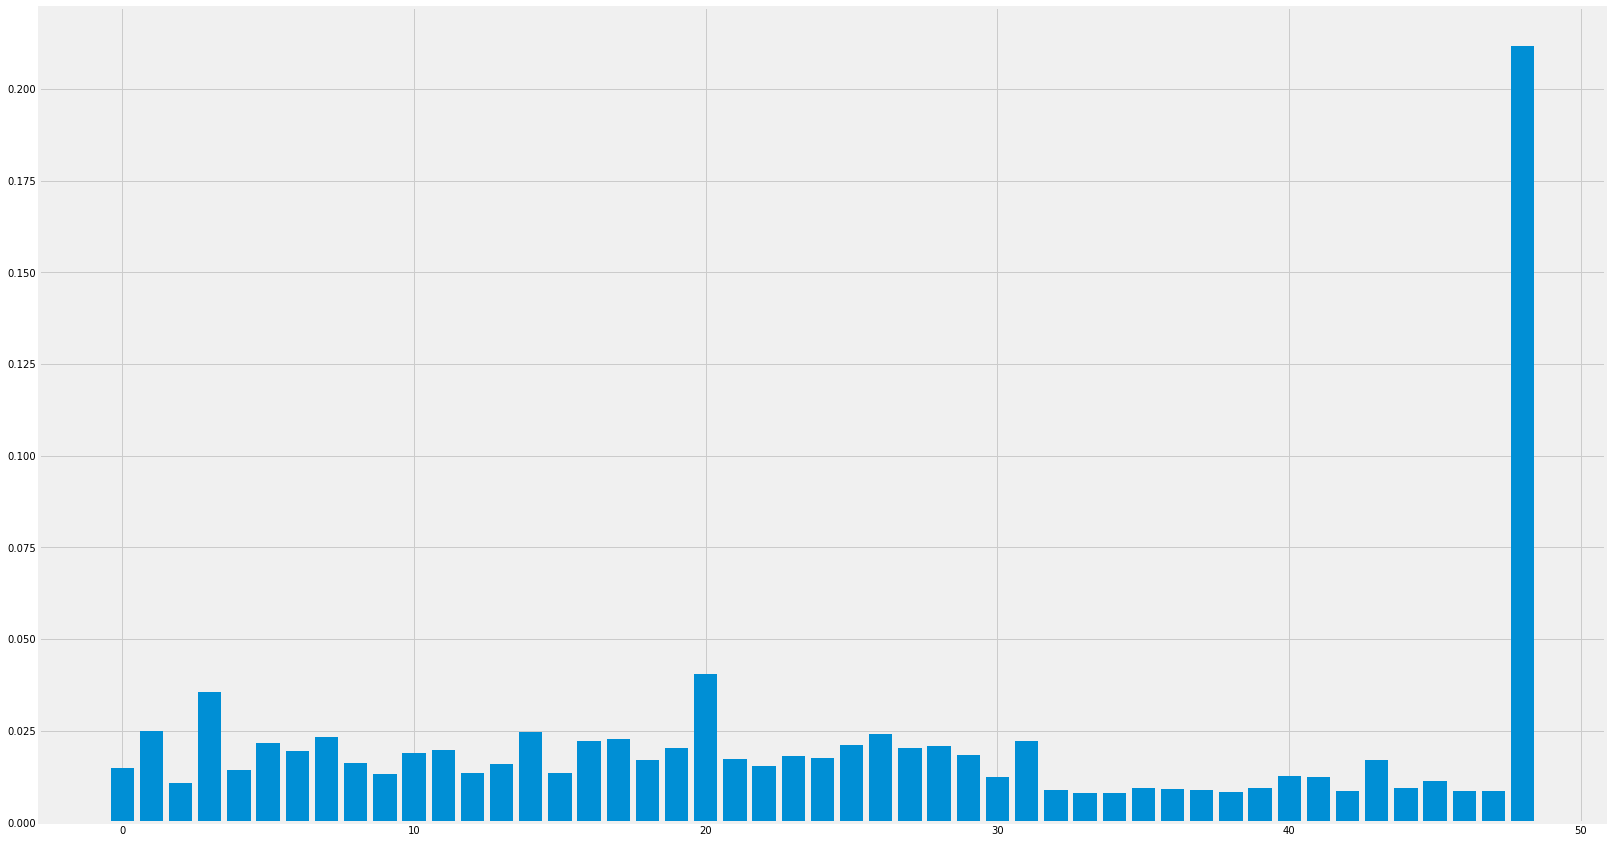

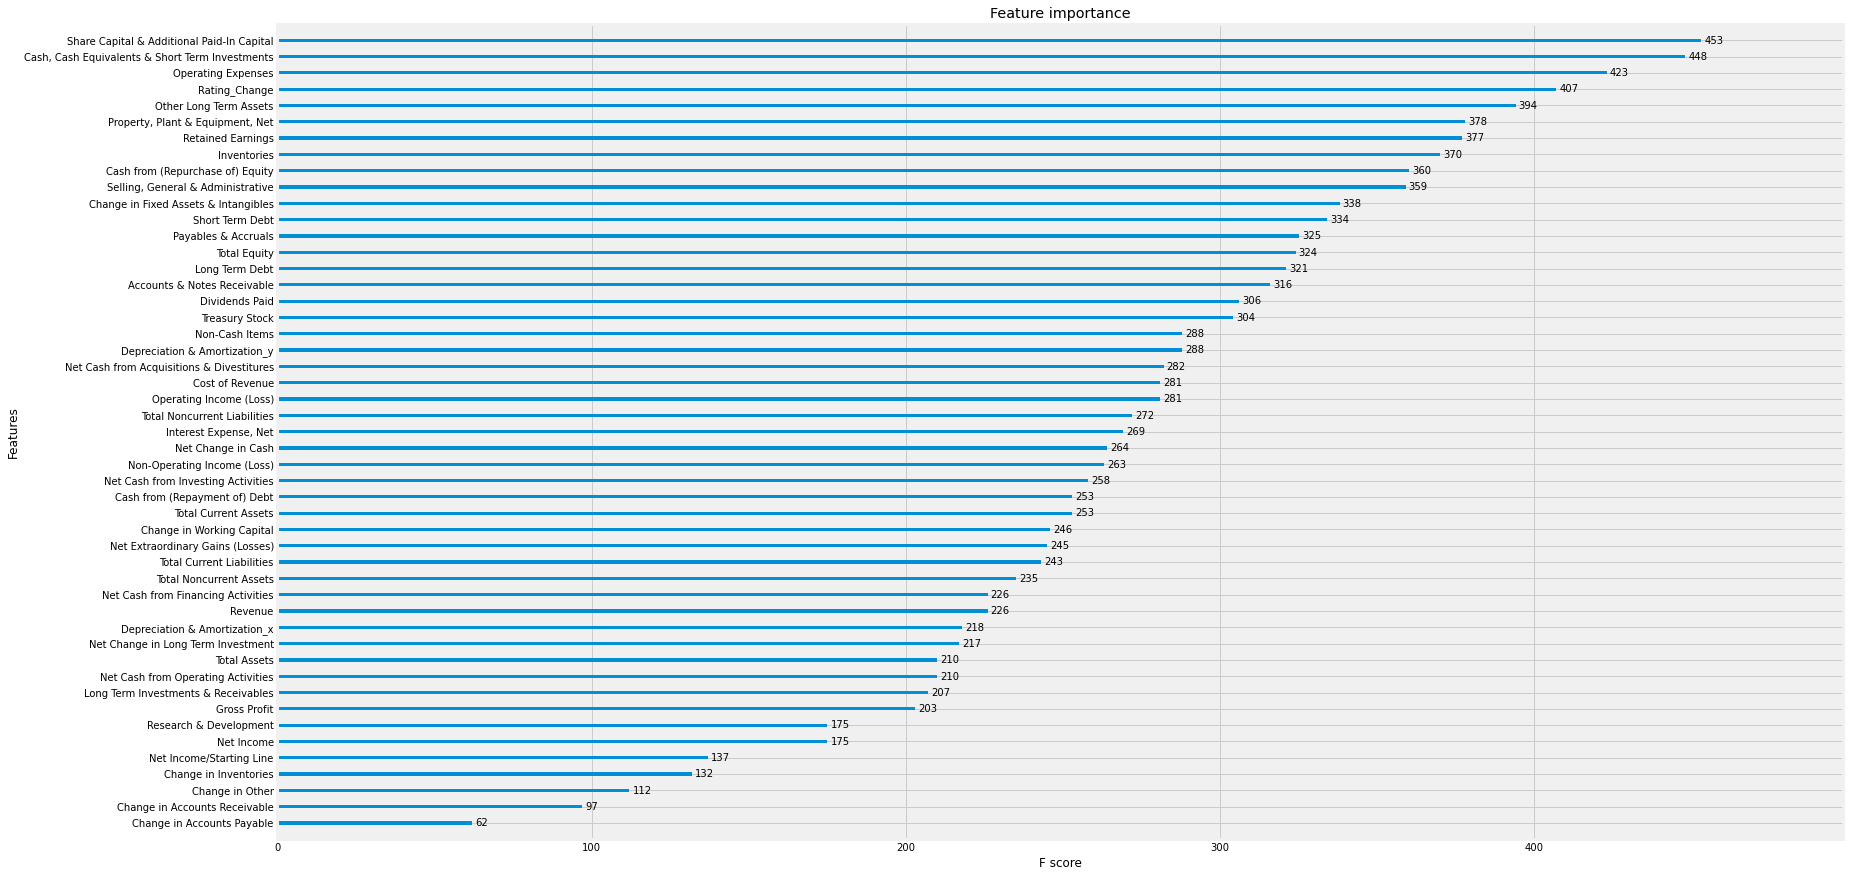

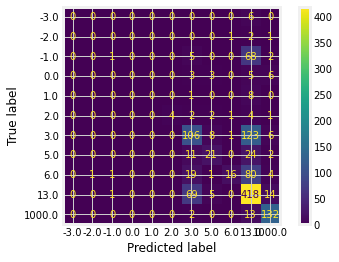

              precision    recall  f1-score   support

        -3.0       0.00      0.00      0.00         6
        -2.0       0.00      0.00      0.00         4
        -1.0       0.33      0.01      0.03        76
         0.0       0.00      0.00      0.00        17
         1.0       0.00      0.00      0.00         9
         2.0       1.00      0.29      0.44        14
         3.0       0.49      0.43      0.46       244
         5.0       0.53      0.36      0.43        58
         6.0       0.84      0.13      0.23       122
        13.0       0.56      0.82      0.66       507
      1000.0       0.79      0.90      0.84       147

    accuracy                           0.58      1204
   macro avg       0.41      0.27      0.28      1204
weighted avg       0.57      0.58      0.53      1204

Precision  0.4117256932757559
Recall  0.26808469943836405
F1  0.2806181163757017
Support  None


In [20]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', max_leaves=7)
eval_set = [(X_hold, y_hold)]
model.fit(X_train, y_train, early_stopping_rounds=10,eval_set=eval_set)
y_predict=model.predict(X_hold)
acc_score = accuracy_score(y_hold, y_predict)

plt.figure(figsize=(25,15)) 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.savefig("feature-bar %s.png" %(str(i)))

fig, ax = plt.subplots(1,1,figsize=(25,15))
plot_importance(model, ax=ax)
plt.savefig("feature %s.png" %(str(i)))

plot_confusion_matrix(model, X_hold , y_hold)
plt.savefig("confusion-matrix %s.png" %(str(i)))
plt.show()

print (classification_report(y_hold, y_predict))
precision, recall, f1, support = precision_recall_fscore_support(y_hold, y_predict, average='macro')
print ("Precision ", precision)
print ("Recall ", recall)
print ("F1 ", f1)
print ("Support ", support)

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', max_leaves=5)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_hold)
accuracy = accuracy_score(y_hold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.))

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_hold)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_hold, predictions)
    f1 = f1_score(y_hold, predictions, average='weighted')
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, F1: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100., f1*100.))

Accuracy: 57.89%
Thresh=0.008, n=49, Accuracy: 57.89%, F1: 53.57%
Thresh=0.009, n=48, Accuracy: 57.64%, F1: 53.56%
Thresh=0.009, n=47, Accuracy: 58.14%, F1: 54.02%
Thresh=0.009, n=46, Accuracy: 58.72%, F1: 54.60%
Thresh=0.009, n=45, Accuracy: 57.97%, F1: 53.95%
Thresh=0.009, n=44, Accuracy: 57.64%, F1: 53.74%
Thresh=0.009, n=43, Accuracy: 58.22%, F1: 54.04%
Thresh=0.010, n=42, Accuracy: 59.39%, F1: 54.97%
Thresh=0.010, n=41, Accuracy: 57.72%, F1: 53.38%
Thresh=0.010, n=40, Accuracy: 58.39%, F1: 54.11%
Thresh=0.010, n=39, Accuracy: 58.72%, F1: 54.85%
Thresh=0.010, n=38, Accuracy: 59.22%, F1: 55.17%
Thresh=0.011, n=37, Accuracy: 57.31%, F1: 53.38%
Thresh=0.012, n=36, Accuracy: 58.80%, F1: 54.56%
Thresh=0.012, n=35, Accuracy: 58.22%, F1: 54.50%
Thresh=0.012, n=34, Accuracy: 57.06%, F1: 53.23%
Thresh=0.012, n=33, Accuracy: 57.14%, F1: 54.01%
Thresh=0.013, n=32, Accuracy: 57.89%, F1: 54.42%
Thresh=0.014, n=31, Accuracy: 58.64%, F1: 54.74%
Thresh=0.014, n=30, Accuracy: 57.89%, F1: 54.07%
Thr

### Overall Score

Classification report shows 0.28 for F1 score, it's not 80%+, but given financial markets uncertainty and for not reading a financial statement, it seems decent. For our features threshold, it seems the scoring is decent.
I believe this methodology can be improved. Part of the futurework is to improve the ratings by integrating SEC footnotes and other technical indicators, such as ATR, volatility factors.  Unfortunately, I do not have access to 10 years tick data. Also categories of sectors should also be a feature as different sector have different metrics.

<b>Drawbacks/Considerations</b>
- I've selected the first earnings report by any analyst when the earnings report is release. This is a very generalized assumption.
- I've also estimated earnings announcement date, not earnings date, rather than finding the actual date.
- Integrating NLP of 3 statements to examine relevancy. That's another project